# Duc Le

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA

In [3]:
# Dataset URL: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv

In [4]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [5]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2).replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)

    ytrain = subset['que_paso']
    return subset, ytrain

In [6]:
data, ytrain = clean(train)

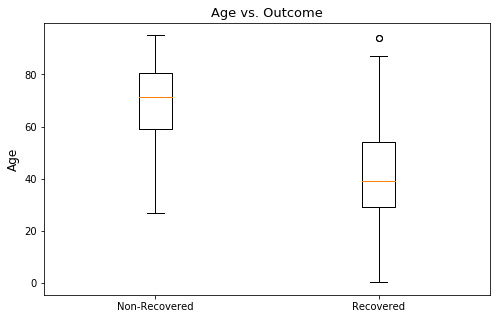

In [7]:
age_death = data['que_paso'] == 0
age_rec = data['que_paso'] == 1

xdeath = data[age_death]
xrec = data[age_rec]

age1 = xdeath['age']
age2 = xrec['age']

data2 = [age1, age2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Outcome', fontsize = 13)

ax.boxplot(data2, labels = ['Non-Recovered', 'Recovered'])
ax.set_ylabel("Age", fontsize = 12)
plt.show()

In [8]:
xtrain = data.drop('que_paso', axis = 1)

In [9]:
clfs = {"AdaBoost": AdaBoostClassifier(random_state = 42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators = 500,
                           n_jobs = -1, min_samples_leaf = 2,
                           bootstrap = True, random_state = 42),
    "Logistic Regression": LogisticRegression(solver = 'saga',
                                             random_state = 42)}
ML = list(clfs.values())
names = list(clfs.keys())

clf = ML[2].fit(xtrain, ytrain)

var_imp = clf.feature_importances_
var = ['Age', 'Sex', 'Country', 'Chronic Disease']

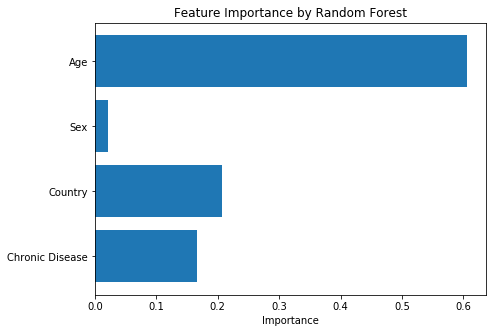

In [10]:
fig, ax = plt.subplots(figsize = (7,5))

y_pos = np.arange(len(var))

ax.barh(y_pos, var_imp, align = 'center')
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis() 
ax.set_xlabel('Importance', fontsize = 10)
ax.set_title('Feature Importance by Random Forest', fontsize = 12)

plt.show()

In [11]:
def confusion_plot(clfs_dict, xtest, ytest):
    ML = list(clfs_dict.values())
    names = list(clfs_dict.keys())
    
    for i in ML:
        disp = plot_confusion_matrix(i, xtest, ytest,
                                     display_labels = ["Not Recovered", "Recovered"],
                                     cmap = 'Blues',
                                     normalize = 'true')
        disp.ax_.set_title("Confusion Matrix: " + names[ML.index(i)])

In [12]:
def classifier(data, clfs_dict):
    selection = 0
    X = data.drop(["que_paso"], axis = 1)
    y = data.iloc[:,-1] 
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.5)
    scaler = StandardScaler()
    scaler.fit(xtrain)
    scaler.fit(xtest)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)

    ML = list(clfs_dict.values())
    names = list(clfs_dict.keys())
    plt.figure(figsize = (7,5))
    
    yprobList = []
    for i in ML:
        clf = i.fit(xtrain,ytrain)
        yprob = clf.predict_proba(xtest)[::,1]
        ypred = clf.predict(xtest)
        fpr, tpr, thresholds = metrics.roc_curve(ytest, yprob)
        auc = round(metrics.auc(fpr,tpr),4)
        acc = round(accuracy_score(ytest, ypred),4)
        
        print("\nThe AUC for", names[ML.index(i)], "is", auc) 
        print("The accuracy score for", names[ML.index(i)], "is", acc)
        
        plt.plot(fpr, tpr, lw = 1, label = names[ML.index(i)]) # + '. AUC: '+ str(auc))
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--')
        plt.xlabel("False Positive Rate", fontsize = 11)
        plt.ylabel("True Positive Rate", fontsize = 11)
        plt.legend()
        plt.title("ROC Curve", fontsize = 13)
        yprobList.append(yprob)
    return xtest, ytest, yprobList


The AUC for AdaBoost is 0.9454
The accuracy score for AdaBoost is 0.8754

The AUC for Naive Bayes is 0.9009
The accuracy score for Naive Bayes is 0.8635

The AUC for Random Forest is 0.9393
The accuracy score for Random Forest is 0.8813

The AUC for Logistic Regression is 0.9098
The accuracy score for Logistic Regression is 0.8694


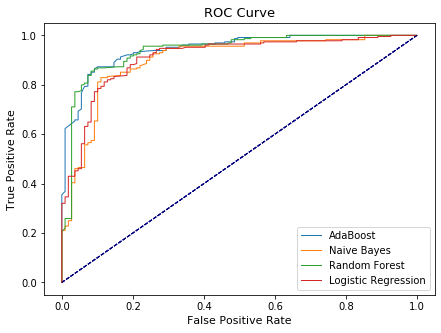

In [13]:
xtest, ytest, yprobList = classifier(data, clfs)

In [14]:
prob_df = pd.DataFrame({"AdaBoost": yprobList[0], "Naive Bayes": yprobList[1],
                       "Random Forest": yprobList[2], "Logistic Regression": yprobList[3]})

In [15]:
print("Probablity of Patients Recovering: ")
prob_df

Probablity of Patients Recovering: 


,AdaBoost,Naive Bayes,Random Forest,Logistic Regression
0,0.505648,0.964962,0.811672,0.737273
1,0.498152,0.000323,0.330160,0.194890
2,0.531069,0.994716,0.990382,0.980588
3,0.685888,0.999701,0.973419,0.987329
4,0.523244,0.976553,0.992869,0.933028
...,...,...,...,...
332,0.520105,0.837061,0.865606,0.751877
333,0.529718,0.970005,0.996309,0.921952
334,0.499113,0.000139,0.540528,0.068076
335,0.475089,0.377373,0.003366,0.247176


In [16]:
clf_RF = {"Param 1": RandomForestClassifier(n_estimators = 500,
                           n_jobs = -1, min_samples_leaf = 1,
                           bootstrap = True, random_state = 42),
          "Param 2": RandomForestClassifier(n_estimators = 100, #changing n_estimators to 5
                           n_jobs = -1, min_samples_leaf = 1,
                           bootstrap = True, random_state = 42),
          "Param 3": RandomForestClassifier(n_estimators = 500,
                           n_jobs = -1, min_samples_leaf = 1,
                           bootstrap = False, random_state = 42), #changing bootstrap to True
          "Param 4": RandomForestClassifier(n_estimators = 500,
                           n_jobs = -1, min_samples_leaf = 100,
                           bootstrap = True, random_state = 42)}

clf_LR = {"Param1": LogisticRegression(penalty = 'elasticnet', solver ='saga',l1_ratio=.5),
          "Param2": LogisticRegression()}


The AUC for Param 1 is 0.9158
The accuracy score for Param 1 is 0.8516

The AUC for Param 2 is 0.9146
The accuracy score for Param 2 is 0.8368

The AUC for Param 3 is 0.8687
The accuracy score for Param 3 is 0.8338

The AUC for Param 4 is 0.8421
The accuracy score for Param 4 is 0.7893


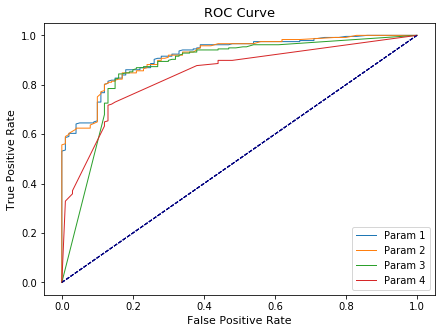

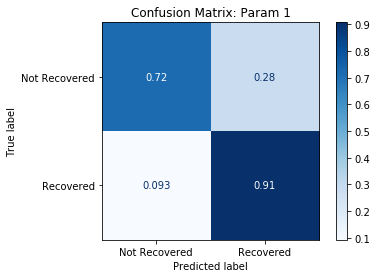

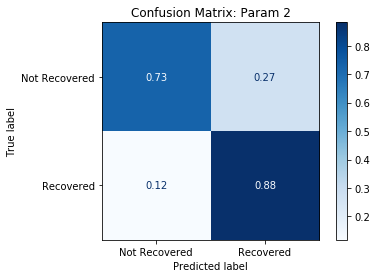

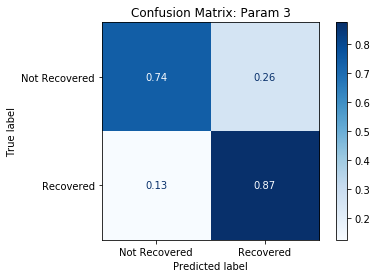

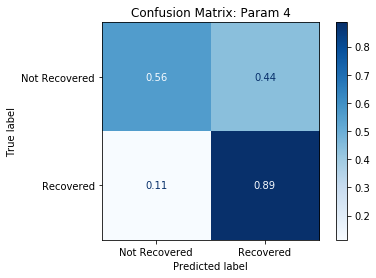

In [17]:
xtest, ytest, _ = classifier(data, clf_RF)
confusion_plot(clf_RF, xtest, ytest)


The AUC for Param1 is 0.8849
The accuracy score for Param1 is 0.8249

The AUC for Param2 is 0.885
The accuracy score for Param2 is 0.8249


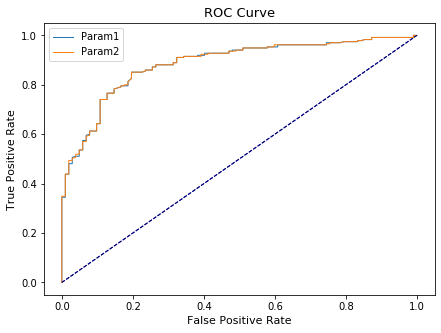

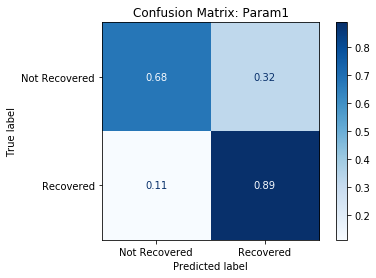

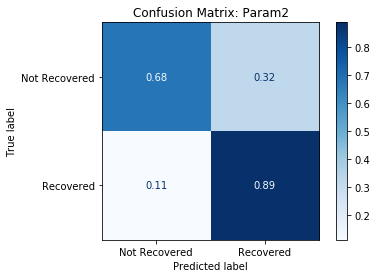

In [18]:
xtest, ytest, _ = classifier(data, clf_LR)
confusion_plot(clf_LR, xtest, ytest)

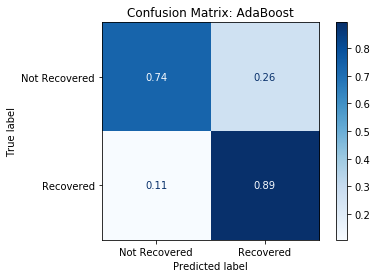

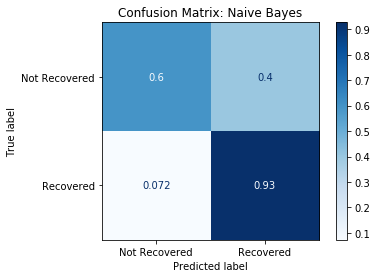

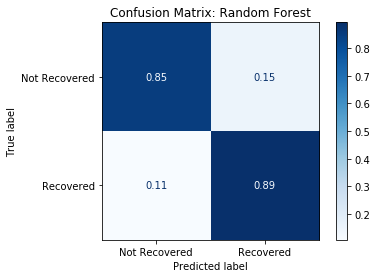

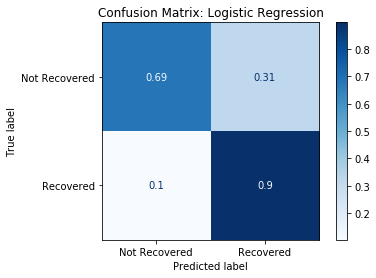

In [19]:
confusion_plot(clfs, xtest, ytest)

In [20]:
def project(data):
    zero = data['que_paso'] == 0
    one = data['que_paso'] == 1
    x0 = data[zero]
    x1 = data[one]
    
    age0 = x0.iloc[:, 0] 
    sex0 = x0.iloc[:, 1] 
    country0 = x0.iloc[:,2]
    chronic0 = x0.iloc[:,3]
    
    age1 = x1.iloc[:,0]
    sex1 = x1.iloc[:,1]
    country1 = x1.iloc[:,2]
    chronic1 = x1.iloc[:,3]
    
    # Visualizing data in higher dimension 
    fig = plt.figure(figsize = (8,6)) 
    ax = fig.add_subplot(111, projection = '3d') 
    ax.scatter(sex0, chronic0, age0, label = 'Non-Recovered')
    ax.scatter(sex1, chronic1, age1, label = 'Recovered')
    ax.set_xlabel("Sex")
    ax.set_ylabel("Chronic Disease (Y/N)")
    ax.set_zlabel("Age")
    plt.legend()
    plt.show()

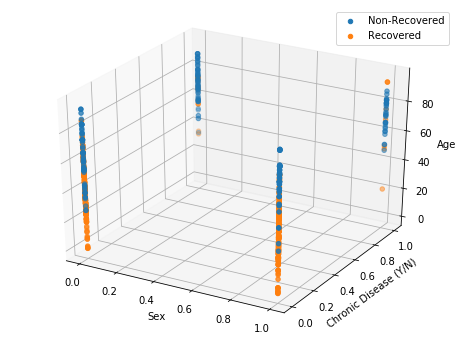

In [21]:
project(data)

In [22]:
def pca(data):
    X = data.drop(['que_paso'], axis = 1)
    y = data['que_paso']
    pca = PCA(n_components = 2)
    pca_components = pca.fit_transform(X)
    return pca_components

In [23]:
def plot_decision_boundary(clf_dict, X, y):
    names = list(clf_dict.keys())
    methods = list(clf_dict.values())
    
    for clf in methods:
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        # Set up plotting mesh
        # Step size of the mesh
        h = .02 
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Perform classification
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        # Plot the decision boundary. For that, we will assign a color to each

        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title(names[methods.index(clf)])

In [24]:
pca_components = pca(data)

C:\Users\Duker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


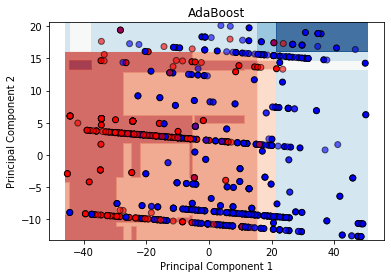

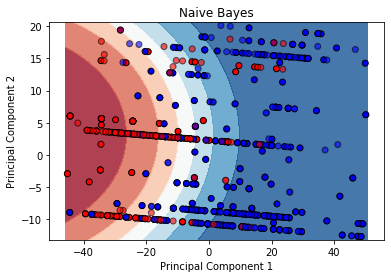

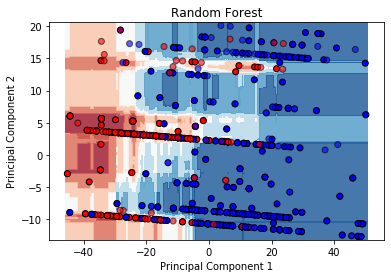

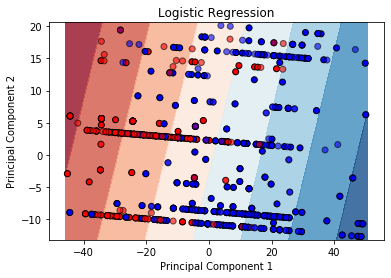

In [25]:
plot_decision_boundary(clfs, pca_components, ytrain)

# Matthew Nwerem

In [26]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [27]:
##This clean function was created by Duc Le, I used it in a little different way

In [28]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2).replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)
    
    xtrain = subset
    ytrain = subset['que_paso']
    return xtrain, ytrain, mp2

In [29]:
xtrain, ytrain, mp2 = clean(train)

In [30]:
xtrain.age.value_counts()

30.0    18
84.5    17
38.0    17
42.0    15
39.0    15
        ..
14.0     1
10.0     1
92.0     1
15.0     1
9.0      1
Name: age, Length: 96, dtype: int64

In [31]:
ytrain.value_counts()

1    455
0    218
Name: que_paso, dtype: int64

In [32]:
xtrain

,age,sex,country,chronic_disease_binary,que_paso
1,78.0,0,1,0,0
2,61.0,1,2,0,1
113,28.0,0,2,0,1
224,56.0,1,2,0,1
335,79.0,1,2,0,1
...,...,...,...,...,...
217292,84.5,1,15,0,0
217293,44.5,1,15,0,1
226430,80.0,1,15,0,0
228855,94.5,1,15,0,0


In [33]:
xtrain.sex.value_counts()

0    406
1    267
Name: sex, dtype: int64

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Linear Regression
##### Sex and Age explain the most amount of data

In [35]:
reg = sm.add_constant(xtrain['age'])
results = sm.OLS(ytrain, reg).fit()
results.summary()

C:\Users\Duker\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               que_paso   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     398.0
Date:                Sun, 24 May 2020   Prob (F-statistic):           6.99e-70
Time:                        22:27:22   Log-Likelihood:                -287.19
No. Observations:                 673   AIC:                             578.4
Df Residuals:                     671   BIC:                             587.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3441      0.036     36.911      0.000       1.273       1.416
age           -0.0134      0.001    -19.950      0.000      -0.015      -0.012
==============================================================================
Omnibus:                       23.503   Durbin-Watson:                   1.347
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.450
Skew:                          -0.268   Prob(JB):                     0.000268
Kurtosis:                       2.452   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
reg = sm.add_constant(xtrain['chronic_disease_binary'])
results = sm.OLS(ytrain, reg).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               que_paso   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     226.6
Date:                Sun, 24 May 2020   Prob (F-statistic):           2.45e-44
Time:                        22:27:22   Log-Likelihood:                -345.99
No. Observations:                 673   AIC:                             696.0
Df Residuals:                     671   BIC:                             705.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.7873      0.017     45.564      0.000       0.753       0.821
chronic_disease_binary    -0.6084      0.040    -15.054      0.000      -0.688      -0.529
==============================================================================
Omnibus:                       73.440   Durbin-Watson:                   1.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.653
Skew:                          -0.927   Prob(JB):                     1.03e-21
Kurtosis:                       3.101   Cond. No.                         2.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
reg = sm.add_constant(xtrain['sex'])
results = sm.OLS(ytrain, reg).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               que_paso   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.554
Date:                Sun, 24 May 2020   Prob (F-statistic):              0.110
Time:                        22:27:22   Log-Likelihood:                -442.63
No. Observations:                 673   AIC:                             889.3
Df Residuals:                     671   BIC:                             898.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6527      0.023     28.115      0.000       0.607       0.698
sex            0.0589      0.037      1.598      0.110      -0.013       0.131
==============================================================================
Omnibus:                     8861.567   Durbin-Watson:                   0.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.564
Skew:                          -0.748   Prob(JB):                     1.09e-26
Kurtosis:                       1.577   Cond. No.                         2.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
columns = xtrain[['age','chronic_disease_binary']]
reg = sm.add_constant(columns)
results = sm.OLS(ytrain, reg).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               que_paso   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     273.8
Date:                Sun, 24 May 2020   Prob (F-statistic):           1.23e-87
Time:                        22:27:22   Log-Likelihood:                -242.89
No. Observations:                 673   AIC:                             491.8
Df Residuals:                     670   BIC:                             505.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.2758      0.035     36.622      0.000       1.207       1.344
age                       -0.0106      0.001    -15.499      0.000      -0.012      -0.009
chronic_disease_binary    -0.3688      0.038     -9.710      0.000      -0.443      -0.294
==============================================================================
Omnibus:                       14.226   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.952
Skew:                          -0.316   Prob(JB):                     0.000567
Kurtosis:                       3.366   Cond. No.                         163.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF comparison shows that our features are not vary correlated to each other

In [39]:
def generate_vif_dataframe(train_data):
    ## Your code goes here

    #for column in data:
        # take all nums in data and do single linreg w/ quality as y
        # get r-squared for that column
        # calcluate_vif(r-sqaured of column)
        # create data frame, column 1 = var name, column 2 = VIF

    varNames = np.array([])
    VIFs = np.array([])

    for column in train_data:
        
        columnObj = train_data.drop(column, axis = 1)
        reg = sm.add_constant(columnObj)
        results = sm.OLS(train_data[column], reg).fit()
        r_sq = results.rsquared
        VIF = calculate_vif(r_sq)

        varNames= np.append(varNames, column)    
        VIFs= np.append(VIFs, VIF)
        
    vif_dataframe = pd.DataFrame({"Variable Name": varNames, "VIF": VIFs})
    
    plt.bar(varNames,VIFs)
    plt.xticks(rotation=50)
    plt.title("VIFs of COVID-19 Data")
    return vif_dataframe

In [40]:
def calculate_vif(r_squared):
    ## Your code goes here
    vif = 1/(1-r_squared)
    
    return vif

,Variable Name,VIF
0,age,1.670313
1,sex,1.018556
2,country,1.022365
3,chronic_disease_binary,1.379227
4,que_paso,1.852313


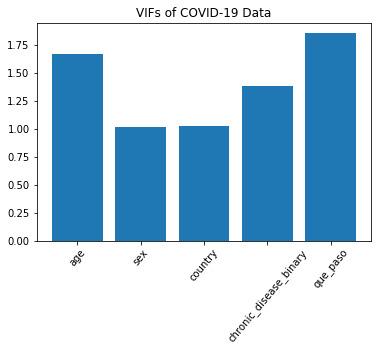

In [41]:
generate_vif_dataframe(xtrain)

### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV

In [43]:
x_train, x_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size = 0.5)

In [44]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(336, 5)
(336,)
(337, 5)
(337,)


In [45]:
y_train = x_train['que_paso']
x_train = x_train.drop('que_paso', axis = 1)

In [46]:
clf1 = LogisticRegression(solver = 'liblinear').fit(x_train,y_train)

In [47]:
x_test

,age,sex,country,chronic_disease_binary,que_paso
82833,82.0,1,13,1,0
82890,66.0,0,13,0,1
18273,54.5,0,7,0,0
65612,63.0,0,23,0,0
69454,30.0,0,27,0,1
...,...,...,...,...,...
61924,82.0,0,0,0,0
43959,51.0,1,2,0,1
67949,48.0,0,27,0,1
74568,84.5,0,7,0,0


In [48]:
x_test['que_paso']

82833    0
82890    1
18273    0
65612    0
69454    1
        ..
61924    0
43959    1
67949    1
74568    0
69813    0
Name: que_paso, Length: 337, dtype: int64

In [49]:
y_test = x_test['que_paso']
x_test = x_test.drop('que_paso', axis = 1)

In [50]:
clf1.predict(x_test)
clf1.score(x_test, y_test)

0.8516320474777448

In [51]:
probability = clf1.predict_proba(x_test)
probability

array([[0.90846471, 0.09153529],
       [0.47705623, 0.52294377],
       [0.28286511, 0.71713489],
       [0.45838058, 0.54161942],
       [0.09036163, 0.90963837],
       [0.55270676, 0.44729324],
       [0.08458917, 0.91541083],
       [0.89411688, 0.10588312],
       [0.67078144, 0.32921856],
       [0.86130348, 0.13869652],
       [0.13133856, 0.86866144],
       [0.86207177, 0.13792823],
       [0.7811733 , 0.2188267 ],
       [0.10997359, 0.89002641],
       [0.38273125, 0.61726875],
       [0.11022414, 0.88977586],
       [0.42154343, 0.57845657],
       [0.1954789 , 0.8045211 ],
       [0.06014946, 0.93985054],
       [0.22370673, 0.77629327],
       [0.93274997, 0.06725003],
       [0.26343491, 0.73656509],
       [0.28286511, 0.71713489],
       [0.75061905, 0.24938095],
       [0.14725151, 0.85274849],
       [0.31893749, 0.68106251],
       [0.04701986, 0.95298014],
       [0.39295924, 0.60704076],
       [0.11470854, 0.88529146],
       [0.08458917, 0.91541083],
       [0.

##### Testing Different Solvers

In [52]:
testing = 0
scores = []
while testing < 300:
    x_train, x_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size = 0.3)
    y_train = x_train['que_paso']
    x_train = x_train.drop('que_paso', axis = 1)
    clf1 = LogisticRegression(solver = 'liblinear').fit(x_train,y_train)
    y_test = x_test['que_paso']
    x_test = x_test.drop('que_paso', axis = 1)
    clf1.predict(x_test)
    scores.append(clf1.score(x_test, y_test))
    testing +=1

In [53]:
import statistics
statistics.mean(scores) 

0.856056105610561

In [54]:
testing = 0
scores = []
while testing < 300:
    x_train, x_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size = 0.3)
    y_train = x_train['que_paso']
    x_train = x_train.drop('que_paso', axis = 1)
    clf1 = LogisticRegression(solver = 'newton-cg').fit(x_train,y_train)
    y_test = x_test['que_paso']
    x_test = x_test.drop('que_paso', axis = 1)
    clf1.predict(x_test)
    scores.append(clf1.score(x_test, y_test))
    testing +=1

In [55]:
import statistics
statistics.mean(scores)

0.8542079207920792

In [56]:
testing = 0
scores = []
while testing < 300:
    x_train, x_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size = 0.3)
    y_train = x_train['que_paso']
    x_train = x_train.drop('que_paso', axis = 1)
    clf1cv = LogisticRegressionCV(cv= 5, solver = 'liblinear').fit(x_train,y_train)
    y_test = x_test['que_paso']
    x_test = x_test.drop('que_paso', axis = 1)
    clf1.predict(x_test)
    scores.append(clf1.score(x_test, y_test))
    testing +=1

In [57]:
statistics.mean(scores)

0.8593894389438944

In [58]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

In [59]:
clf1 = LogisticRegression(solver = 'newton-cg').fit(x_train,y_train)

y_pred = clf1.predict(x_test)
y_prob = clf1.predict_proba(x_test)

In [60]:
var = ['Age', 'Sex','Country', 'Chronic Disease']

Feature: 0, Score: -0.09942
Feature: 1, Score: 0.71865
Feature: 2, Score: -0.02804
Feature: 3, Score: -1.56188


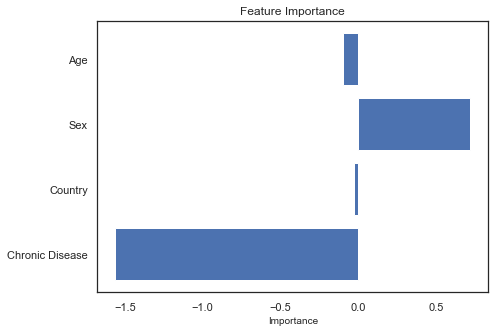

In [61]:
importance = clf1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, ax = plt.subplots(figsize = (7,5))
y_pos = np.arange(len(var))

#ax.barh(y_pos, var_imp, align='center')
ax.barh([x for x in range(len(importance))], importance)
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis() 
ax.set_xlabel('Importance', fontsize = 10)
ax.set_title('Feature Importance', fontsize = 12)

plt.show()

The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

In [62]:
from sklearn.decomposition import PCA

In [63]:
pca = PCA(n_components=2)
principalcomponents = pca.fit_transform(x_train)
print(pca.explained_variance_ratio_)

principle_df = pd.DataFrame({'PCA 1': principalcomponents[:,0], 'PCA 2': principalcomponents[:,1], 'target':y_train})
#final_df = principle_df
#principle_df["target"] = y_train

print(principle_df)

[0.8400211 0.1593497]
            PCA 1      PCA 2  target
3556    22.621820 -11.269135       1
42628   -4.295578  -8.368993       1
82841  -37.916290   3.760654       0
83100   -9.924885   2.825152       1
75859   13.693860  -8.969831       1
...           ...        ...     ...
177554 -15.854606   5.024316       0
89772  -23.351335  -9.732822       0
84786   -9.924885   2.825152       0
90477   14.626366 -11.001257       1
11205  -14.356617 -10.033241       1

[471 rows x 3 columns]


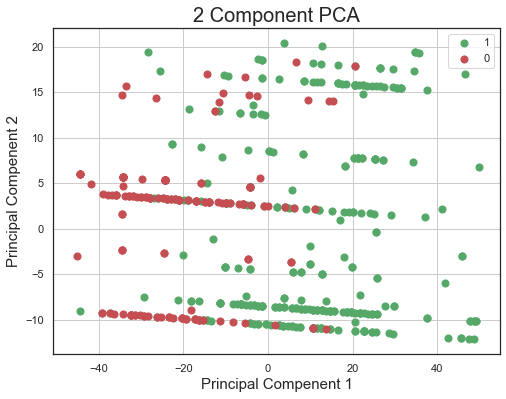

In [64]:
fig = plt.figure(figsize=(8, 6))
ax =  fig.add_subplot(1,1,1)
ax.set_xlabel("Principal Compenent 1", fontsize = 15)
ax.set_ylabel("Principal Compenent 2", fontsize = 15)
ax.set_title("2 Component PCA", fontsize = 20)

targets = [1,0]
colors = ['g', 'r']
for target, color in zip(targets, colors):
    indicesToKeep = y_train == target
    ax.scatter(principle_df.loc[indicesToKeep, "PCA 1"],
              principle_df.loc[indicesToKeep, "PCA 2"],
              c = color,
              s = 50)

ax.legend(targets)
ax.grid()

# Riley Kendall

In [65]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [66]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2)
    subset = subset.replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)
    xtrain = subset.drop('que_paso', axis = 1)
    ytrain = subset['que_paso']
    return xtrain, ytrain

In [67]:
xtrain, ytrain = clean(train)
xtrain['outcome'] = ytrain
all_ds = xtrain

In [68]:
d = all_ds['outcome'] == 0
r= all_ds['outcome'] == 1

In [69]:
#Sex Information
m = all_ds['sex'] == 0
f = all_ds['sex'] == 1

count_s = all_ds['sex'].value_counts()
m_t = count_s[0]
f_t = count_s[1]

m_d = (len(all_ds[m & d])/m_t)*100
f_d = (len(all_ds[f & d])/f_t)*100
m_r = (len(all_ds[m & r])/m_t)*100
f_r = (len(all_ds[f & r])/f_t)*100

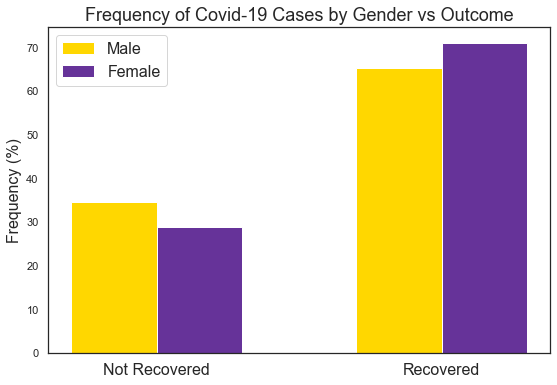

In [70]:
#Freq Sex vs Outcome Plot
labels = ['Not Recovered', 'Recovered']

M = [m_d,m_r]
F = [f_d,f_r]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize = (9,6))
rects1 = ax.bar(x - .5*width, M, width, label='Male', color = 'gold')
rects2 = ax.bar(x + .5*width, F, width, label='Female', color = 'rebeccapurple')

ax.set_ylabel('Frequency (%)', fontsize=16)
ax.set_title('Frequency of Covid-19 Cases by Gender vs Outcome', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend(loc='best', fontsize=16)

plt.show()


In [71]:
#Chronic Disease
n_ch = all_ds['chronic_disease_binary'] == 0
ch = all_ds['chronic_disease_binary'] == 1

count_ch = all_ds['chronic_disease_binary'].value_counts()
n_ch_t = count_ch[0]
ch_t = count_ch[1]

n_ch_d = (len(all_ds[n_ch & d])/m_t)*100
ch_d = (len(all_ds[ch & d])/f_t)*100
n_ch_r = (len(all_ds[n_ch & r])/m_t)*100
ch_r = (len(all_ds[ch & r])/f_t)*100

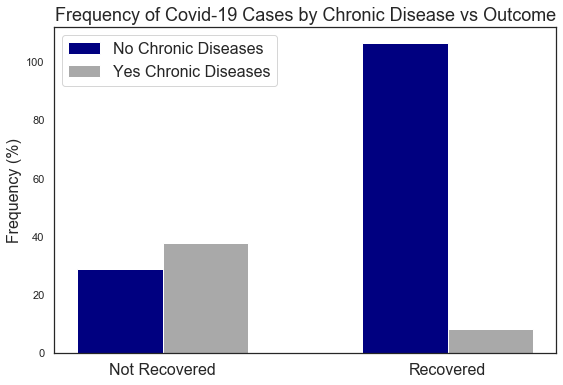

In [72]:
#Freq Sex vs Outcome Plot
labels = ['Not Recovered', 'Recovered']

N_CH = [n_ch_d,n_ch_r]
CH = [ch_d,ch_r]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize = (9,6))
rects1 = ax.bar(x - .5*width, N_CH, width, label='No Chronic Diseases', color = 'navy')
rects2 = ax.bar(x + .5*width, CH, width, label='Yes Chronic Diseases', color = 'darkgrey')

ax.set_ylabel('Frequency (%)', fontsize=16)
ax.set_title('Frequency of Covid-19 Cases by Chronic Disease vs Outcome', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend(loc='best', fontsize=16)

plt.show()

In [73]:
#Country Information
China = all_ds['country'] == 0
Italy = all_ds['country'] == 1
US = all_ds['country'] == 15
Vietnam = all_ds['country'] == 19

count_c = all_ds['country'].value_counts()
China_t = count_c[0]
Italy_t = count_c[1]
US_t = count_c[15]
Vietnam_t = count_c[19]

#death
China_d = (len(all_ds[China & d])/China_t)*100
Italy_d = (len(all_ds[Italy & d])/Italy_t)*100
US_d = (len(all_ds[US & d])/US_t)*100
Vietnam_d = (len(all_ds[Vietnam & d])/Vietnam_t)*100

#recovery
China_r = (len(all_ds[China & r])/China_t)*100
Italy_r = (len(all_ds[Italy & r])/Italy_t)*100
US_r = (len(all_ds[US & r])/US_t)*100
Vietnam_r = (len(all_ds[Vietnam & r])/Vietnam_t)*100

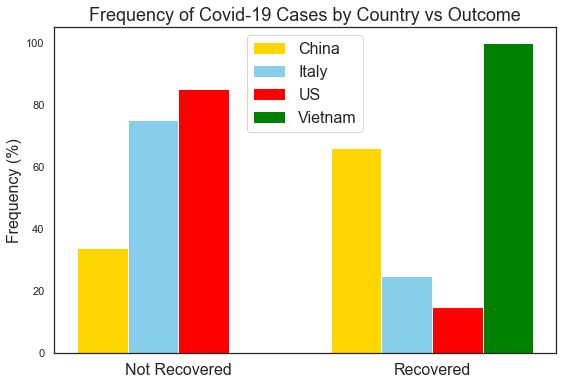

<Figure size 360x360 with 0 Axes>

In [74]:
#Freq Sex vs Outcome Plot
labels = ['Not Recovered', 'Recovered']

CH = [China_d,China_r]
IT = [Italy_d,Italy_r]
US = [US_d,US_r]
VI = [Vietnam_d,Vietnam_r]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize = (9,6))
rects1 = ax.bar(x - 1.5*width, CH, width, label='China', color = 'gold')
rects2 = ax.bar(x - .5*width, IT, width, label='Italy', color = 'skyblue')
rects2 = ax.bar(x + .5*width, US, width, label='US', color = 'red')
rects1 = ax.bar(x + 1.5*width, VI, width, label='Vietnam', color = 'green')

ax.set_ylabel('Frequency (%)', fontsize=16)
ax.set_title('Frequency of Covid-19 Cases by Country vs Outcome', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend(loc = 'best', fontsize=16)

#fig.tight_layout()
fig = plt.figure(figsize = (5,5))

plt.show()

In [75]:
#print(all_ds)
pd.set_option('display.max_rows', all_ds.shape[0]+1)
#all_ds
count_o = all_ds['outcome'].value_counts()
count_o

1    455
0    218
Name: outcome, dtype: int64

In [76]:
d = all_ds['outcome'] == 0
r= all_ds['outcome'] == 1

#Sex Information
m = all_ds['sex'] == 0
f = all_ds['sex'] == 1

count_s = all_ds['sex'].value_counts()
m_t = count_s[0]
f_t = count_s[1]

m_d = (len(all_ds[m & d])/m_t)*100
f_d = (len(all_ds[f & d])/f_t)*100
m_r = (len(all_ds[m & r])/m_t)*100
f_r = (len(all_ds[f & r])/f_t)*100


#Chronic Disease
n_ch = all_ds['chronic_disease_binary'] == 0
ch = all_ds['chronic_disease_binary'] == 1

count_ch = all_ds['chronic_disease_binary'].value_counts()
n_ch_t = count_ch[0]
ch_t = count_ch[1]

n_ch_d = (len(all_ds[n_ch & d])/m_t)*100
ch_d = (len(all_ds[ch & d])/f_t)*100
n_ch_r = (len(all_ds[n_ch & r])/m_t)*100
ch_r = (len(all_ds[ch & r])/f_t)*100

#Country Information
China = all_ds['country'] == 0
Italy = all_ds['country'] == 1
US = all_ds['country'] == 15
Vietnam = all_ds['country'] == 19

count_c = all_ds['country'].value_counts()
China_t = count_c[0]
Italy_t = count_c[1]
US_t = count_c[15]
Vietnam_t = count_c[19]

#death
China_d = (len(all_ds[China & d])/China_t)*100
Italy_d = (len(all_ds[Italy & d])/Italy_t)*100
US_d = (len(all_ds[US & d])/US_t)*100
Vietnam_d = (len(all_ds[Vietnam & d])/Vietnam_t)*100

#recovery
China_r = (len(all_ds[China & r])/China_t)*100
Italy_r = (len(all_ds[Italy & r])/Italy_t)*100
US_r = (len(all_ds[US & r])/US_t)*100
Vietnam_r = (len(all_ds[Vietnam & r])/Vietnam_t)*100

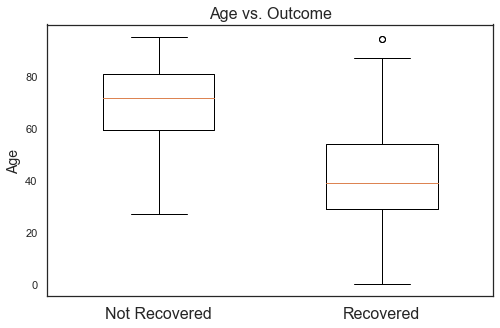

In [77]:
age_death = xtrain['outcome'] == 0
age_rec = xtrain['outcome'] == 1

xdeath = xtrain[age_death]
xrec = xtrain[age_rec]

col1 = xdeath['age']
col2 = xrec['age']

data = [col1, col2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Outcome', fontsize=16)

ax.boxplot(data, labels = ['Non-Recovered', 'Recovered'], widths = 0.5)
ax.set_ylabel("Age", fontsize=14)
ax.set_xticklabels(labels, fontsize=16)
plt.show()

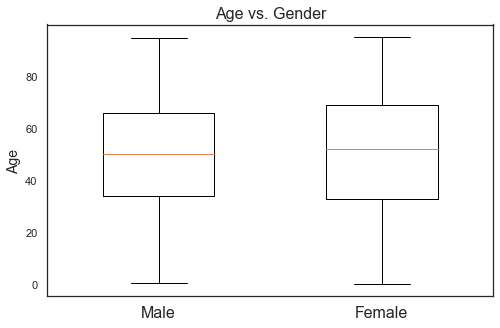

<Figure size 432x288 with 0 Axes>

In [78]:
age_male = xtrain['sex'] == 0
age_female = xtrain['sex'] == 1

xmale = xtrain[age_male]
xfemale = xtrain[age_female]

col1 = xmale['age']
col2 = xfemale['age']

data_age = [col1, col2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Gender', fontsize=16)
labels = ['Male', 'Female']

plt.figure()
ax.boxplot(data_age, labels= ['Male', 'Female'], widths = 0.5)
ax.set_ylabel("Age", fontsize=14)
ax.set_xticklabels(labels, fontsize=16)
plt.show()

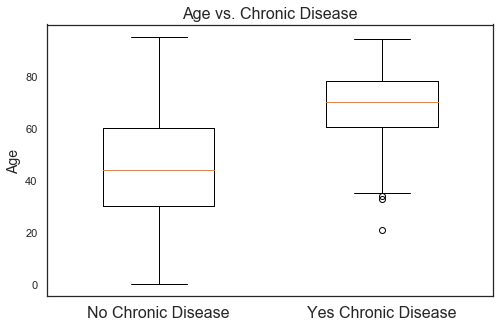

<Figure size 432x288 with 0 Axes>

In [79]:
n_ch = all_ds['chronic_disease_binary'] == 0
ch = all_ds['chronic_disease_binary'] == 1

xn_ch = xtrain[n_ch]
xch = xtrain[ch]

col1 = xn_ch['age']
col2 = xch['age']

data_age = [col1, col2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Chronic Disease', fontsize=16)

labels=['No Chronic Disease', 'Yes Chronic Disease']

plt.figure()
ax.boxplot(data_age, widths = 0.5)
ax.set_ylabel("Age", fontsize=14)
ax.set_xticklabels(labels, fontsize=16)
plt.show()

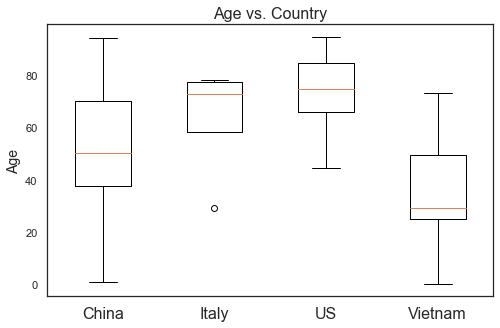

<Figure size 432x288 with 0 Axes>

In [80]:
China = all_ds['country'] == 0
Italy = all_ds['country'] == 1
US = all_ds['country'] == 15
Vietnam = all_ds['country'] == 19

xChina = xtrain[China]
xItaly = xtrain[Italy]
xUS = xtrain[US]
xVietnam = xtrain[Vietnam]

col1 = xChina['age']
col2 = xItaly['age']
col3 = xUS['age']
col4 = xVietnam['age']

data_age = [col1, col2, col3, col4]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Country', fontsize=16)

labels=['China','Italy','US','Vietnam']

plt.figure()
ax.boxplot(data_age, widths = 0.5)
ax.set_ylabel("Age", fontsize=14)
ax.set_xticklabels(labels, fontsize=16)
plt.show()

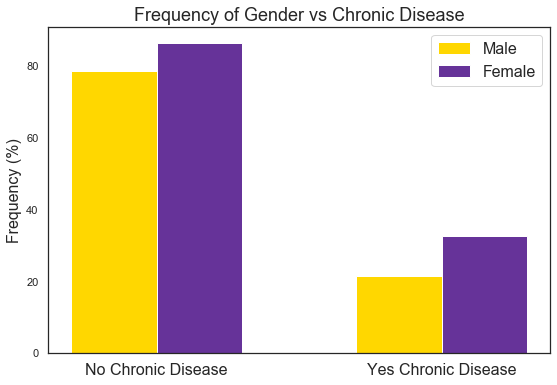

In [81]:
#Sex Information
#Freq Sex vs Chronic Disease Plot
labels = ['No Chronic Disease', 'Yes Chronic Disease']

m_n_ch = (len(all_ds[m & n_ch])/m_t)*100
f_n_ch = (len(all_ds[f & n_ch])/f_t)*100
m_ch = (len(all_ds[m & ch])/m_t)*100
f_ch = (len(all_ds[m & ch])/f_t)*100

M_dis = [m_n_ch,m_ch]
F_dis = [f_n_ch,f_ch]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize = (9,6))
rects1 = ax.bar(x - .5*width, M_dis, width, label='Male', color = 'gold')
rects2 = ax.bar(x + .5*width, F_dis, width, label='Female', color = 'rebeccapurple')

ax.set_ylabel('Frequency (%)', fontsize=16)
ax.set_title('Frequency of Gender vs Chronic Disease', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend(loc='best', fontsize=16)

plt.show()

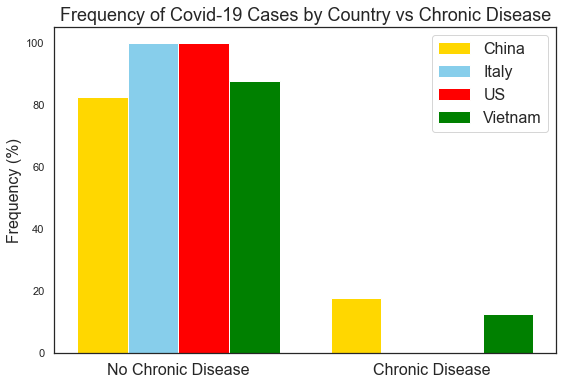

In [82]:
#Country Information


#Country Information
China = all_ds['country'] == 0
Italy = all_ds['country'] == 1
US = all_ds['country'] == 15
Vietnam = all_ds['country'] == 19

count_c = all_ds['country'].value_counts()
China_t = count_c[0]
Italy_t = count_c[1]
US_t = count_c[15]
Vietnam_t = count_c[19]

#no chronic disease
China_n_ch = (len(all_ds[China & n_ch])/China_t)*100
Italy_n_ch = (len(all_ds[Italy & n_ch])/Italy_t)*100
US_n_ch = (len(all_ds[US & n_ch])/US_t)*100
Vietnam_n_ch = (len(all_ds[Vietnam & n_ch])/Vietnam_t)*100

#chronic disease
China_ch = (len(all_ds[China & ch])/China_t)*100
Italy_ch = (len(all_ds[Italy & ch])/Italy_t)*100
US_ch = (len(all_ds[US & ch])/US_t)*100
Vietnam_ch = (len(all_ds[Vietnam & ch])/Vietnam_t)*100

#Freq Sex vs Outcome Plot
labels = ['No Chronic Disease', 'Chronic Disease']

CH = [China_n_ch,China_ch]
IT = [Italy_n_ch,Italy_ch]
US = [US_n_ch,US_ch]
VI = [Vietnam_n_ch,Vietnam_ch]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize = (9,6))
rects1 = ax.bar(x - 1.5*width, CH, width, label='China', color = 'gold')
rects2 = ax.bar(x - .5*width, IT, width, label='Italy', color = 'skyblue')
rects2 = ax.bar(x + .5*width, US, width, label='US', color = 'red')
rects1 = ax.bar(x + 1.5*width, VI, width, label='Vietnam', color = 'green')

ax.set_ylabel('Frequency (%)', fontsize=16)
ax.set_title('Frequency of Covid-19 Cases by Country vs Chronic Disease', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend(loc= 'best', fontsize=16)
plt.show()